In [1]:
from BlackBoxOptimizer import Optimizer, EvolutionaryOpt, SimulatedAnnealingOptimizer, GaussOpt
from Models import SquareSumModel, SinParabolaModel

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import statistics
from math import sqrt
import math

In [22]:
target = np.array([-0.8, 1.2])
model = SquareSumModel(-target)

model = SinParabolaModel(a = -target, b=2, c=10)

In [24]:
model.evaluate([-0.8, 1.2])

array([-4.])

In [25]:
optimizer = Optimizer(
            optCls=EvolutionaryOpt,
            seed=42,
            to_model_vec_size=2,
            from_model_vec_size=3,
            iter_limit=60,
            external_model=model.evaluate,
            dimension=2,
            population_size=30,
            offspring_per_parent=2,
            mutation_prob=0.3,
            sigma_init=0.2,
            t_max=100
        )

for i in range(2):  # Первые 3 параметра - непрерывные
    optimizer.setVecItemLimit(i, "to_model", min=-3, max=3)

# optimizer.setVecItemLimit(0, "from_model", min=1, max=np.inf)

optimizer.modelOptimize()
ep_optimizer = optimizer.getOptimizer()
history = ep_optimizer.get_optimization_history()
best_solution = ep_optimizer._to_opt_model_data.vecs[:, 0]

x_hist = np.empty([len(history), 2])
y_hist = np.empty([len(history), 1])
for i, gen in enumerate(history):
    x = gen['best_solution']
    x_hist[i, :] = x
    y_hist[i] = model.evaluate(x)


print(' Итог MV', x_hist[-1])
print(' Итог СV', y_hist[-1])
print(' Итог L1', np.sum(np.abs(x_hist[-1]-target)))
print(' число обращений к оракулу', optimizer.get_usage_count())

 Итог MV [-0.80989075  1.19952321]
 Итог СV [-3.99010449]
 Итог L1 0.010367541722078544
 число обращений к оракулу 5370


In [34]:
import warnings

warnings.filterwarnings('ignore')

optimizer = Optimizer(
        optCls              = GaussOpt,
        seed                = 1468, # TODO: Проверить, точно ли работает. Сейчас выдаёт разные значения при одном seed
        to_model_vec_size   = 2,
        from_model_vec_size = 1,
        iter_limit          = 50,
        external_model = model.evaluate
        )
optimizer.configure(kernel_cfg=('RBF', {}))
for i in range(2):  # Первые 3 параметра - непрерывные
    optimizer.setVecItemLimit(i, "to_model", min=-3, max=3)
optimizer.setVecItemLimit(1, "from_model", min=1, max=np.inf)
optimizer.modelOptimize()

currentOptimizer = optimizer.getOptimizer()

x_hist = currentOptimizer.history_to_opt_model_data.copy()

y_hist = np.empty([len(x_hist), 1])
for i, gen in enumerate(x_hist):
    y_hist[i] = model.evaluate(gen).copy()

x = optimizer.getResult()
print(' Итог MV', x)
print(' Итог СV',model.evaluate(x))
print(' Итог L1', np.sum(np.abs(x-target)))
print(' число обращений к оракулу', optimizer.get_usage_count())

 Итог MV [-0.24028301 -0.06396613]
 Итог СV [-1.6312899]
 Итог L1 1.8236831246231335
 число обращений к оракулу 90


In [36]:
optimizer = Optimizer(
        optCls=SimulatedAnnealingOptimizer,
        seed=1424,
        to_model_vec_size=2,
        from_model_vec_size=1,
        iter_limit=1000,  # Уменьшил для более компактного вывода
        external_model=model.evaluate,
        initial_temp=50.0,
        min_temp=1e-5,
        cooling_rate=0.98,
        step_size=0.8,
        penalty_coef=1e6  
    )

for i in range(2):  # Первые 3 параметра - непрерывные
    optimizer.setVecItemLimit(i, "to_model", min=-3, max=3)
# optimizer.setVecItemLimit(1, "from_model", min=1, max=np.inf)
optimizer.modelOptimize()

archive_vectors, archive_energies, archive_outputs = optimizer.getOptimizer().get_archive()
y_hist = archive_outputs[:1000:20, 0]
x_hist = archive_vectors[:1000:20]

x = optimizer.getResult()
print(' Итог MV', x)
print(' Итог СV',model.evaluate(x))
print(' Итог L1', np.sum(np.abs(x-target)))
print(' число обращений к оракулу', optimizer.get_usage_count())

 Итог MV [-0.80011331  1.20044083]
 Итог СV [-3.99997908]
 Итог L1 0.0005541478312781623
 число обращений к оракулу 3000


In [146]:
currentOptimizer = optimizer.getOptimizer()

a = currentOptimizer.history_to_opt_model_data

In [131]:
x_hist[0]

array([ 0.31177945, -0.5924081 ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


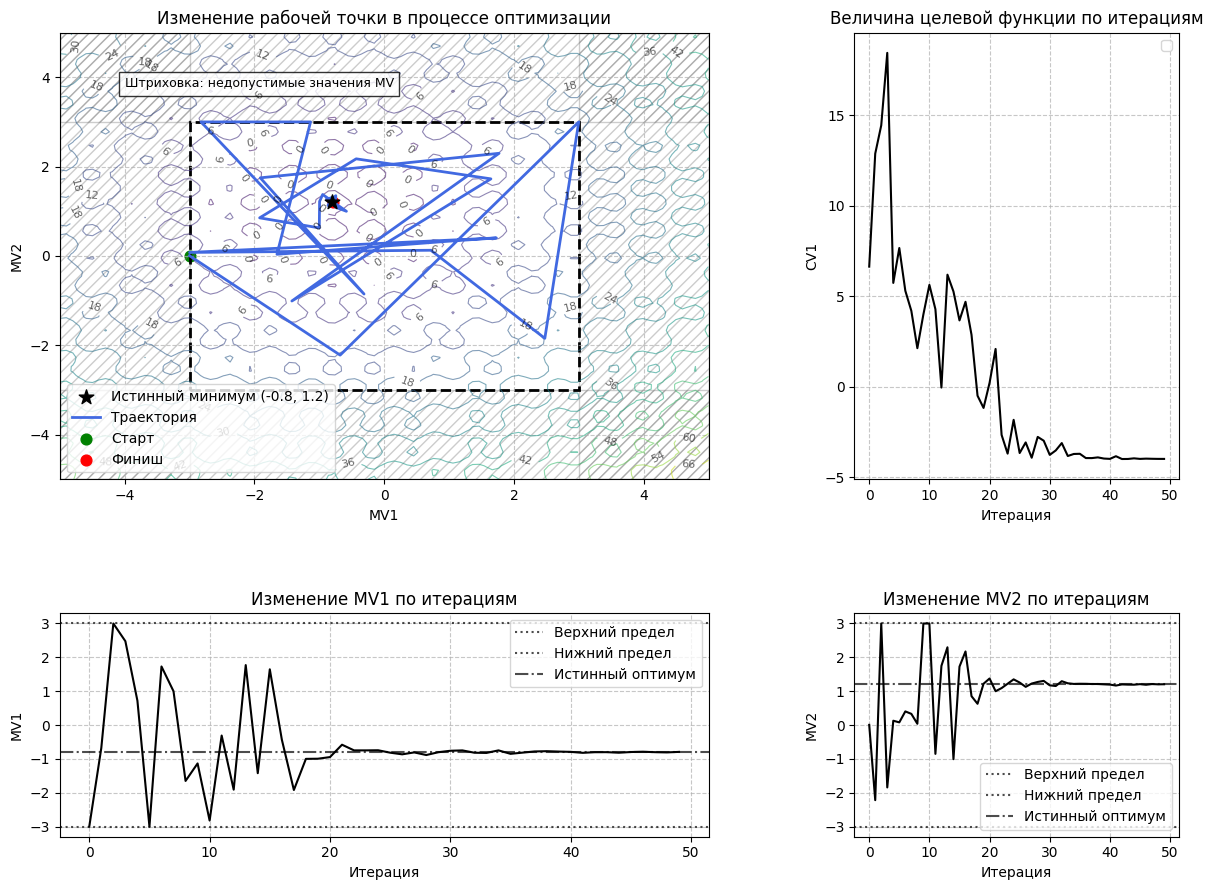

In [37]:

# Создание фигуры с несколькими субплогами
fig = plt.figure(figsize=(12, 9))

# Настройка сетки графиков
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])

# 1. График траектории с линиями уровня
ax1 = fig.add_subplot(gs[0, 0])

# Создание сетки для линий уровня
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_range, y_range)

# Пример функции для линий уровня (можно заменить на свою)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = model.evaluate([X[i,j], Y[i,j]])

# Рисование линий уровня
contour = ax1.contour(X, Y, Z, 
                     levels=12,
                     cmap='viridis',
                     linewidths=0.8,
                     alpha=0.6)

# Подписи линий уровня
ax1.clabel(contour, inline=True, fontsize=8, colors='k')

ax1.scatter(target[0], target[1], s=120, c='black', 
          edgecolor='black', marker='*', 
          label=f'Истинный минимум ({target[0]}, {target[1]})', zorder=5)

# Траектория движения
ax1.plot(x_hist[:, 0], x_hist[:, 1], c='royalblue', linewidth=2, label='Траектория')
ax1.scatter(x_hist[0, 0], x_hist[0, 1], c='green', s=60, label='Старт')
ax1.scatter(x_hist[-1, 0], x_hist[-1, 1], c='red', s=60, label='Финиш')

ax1.set_title('Изменение рабочей точки в процессе оптимизации')
ax1.set_xlabel('MV1', fontsize=10)
ax1.set_ylabel('MV2', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

ax1.fill_betweenx(y_range, 3, 5, 
                hatch='///', edgecolor='gray', 
                facecolor='none', alpha=0.4, label='Недопустимая зона')
ax1.fill_betweenx(y_range, -5, -3, 
                hatch='///', edgecolor='gray', 
                facecolor='none', alpha=0.4)
ax1.fill_between(x_range, 3, 5, 
               hatch='///', edgecolor='gray', 
               facecolor='none', alpha=0.4)
ax1.fill_between(x_range, -5, -3, 
               hatch='///', edgecolor='gray', 
               facecolor='none', alpha=0.4)

ax1.add_patch(patches.Rectangle((-3, -3), 6, 6,
            linewidth=2, linestyle='--', edgecolor='black', 
            facecolor='none', label='Зона допустимых значений MV'))


# ax1.add_patch(patches.Circle((target[0], target[1]), 1,  hatch='///',
#             linewidth=2, linestyle='-.', edgecolor='black', 
#             facecolor='none', label='Зона допустимых значений CV'))

ax1.text(0.1, 0.9, 'Штриховка: недопустимые значения MV',
       transform=ax1.transAxes,
       fontsize=9,
       verticalalignment='top',
       bbox=dict(facecolor='white', alpha=0.8))

# Остальные графики без изменений
# 2. График дополнительной переменной (Z)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(y_hist, c='black')
ax2.set_title('Величина целевой функции по итерациям', fontsize=12)
# ax2.axhline(1.0, color='black', linestyle=':', alpha=0.7, label='CV min')
ax2.set_xlabel('Итерация', fontsize=10)
ax2.set_ylabel('CV1', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# 3. Графики скорости по осям
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(x_hist[:,0], c='black')
ax3.axhline(3.0, color='black', linestyle=':', alpha=0.7, label='Верхний предел')
ax3.axhline(-3.0, color='black', linestyle=':', alpha=0.7, label='Нижний предел')
ax3.axhline(target[0], color='black', linestyle='-.', alpha=0.7, label='Истинный оптимум')
ax3.set_title('Изменение MV1 по итерациям', fontsize=12)
ax3.set_xlabel('Итерация', fontsize=10)
ax3.set_ylabel('MV1', fontsize=10)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(x_hist[:,1], c='black')
ax4.axhline(3.0, color='black', linestyle=':', alpha=0.7, label='Верхний предел')
ax4.axhline(-3.0, color='black', linestyle=':', alpha=0.7, label='Нижний предел')
ax4.axhline(target[1], color='black', linestyle='-.', alpha=0.7, label='Истинный оптимум')
ax4.set_title('Изменение MV2 по итерациям', fontsize=12)
ax4.set_xlabel('Итерация', fontsize=10)
ax4.set_ylabel('MV2', fontsize=10)
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.legend()

# Регулировка отступов
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

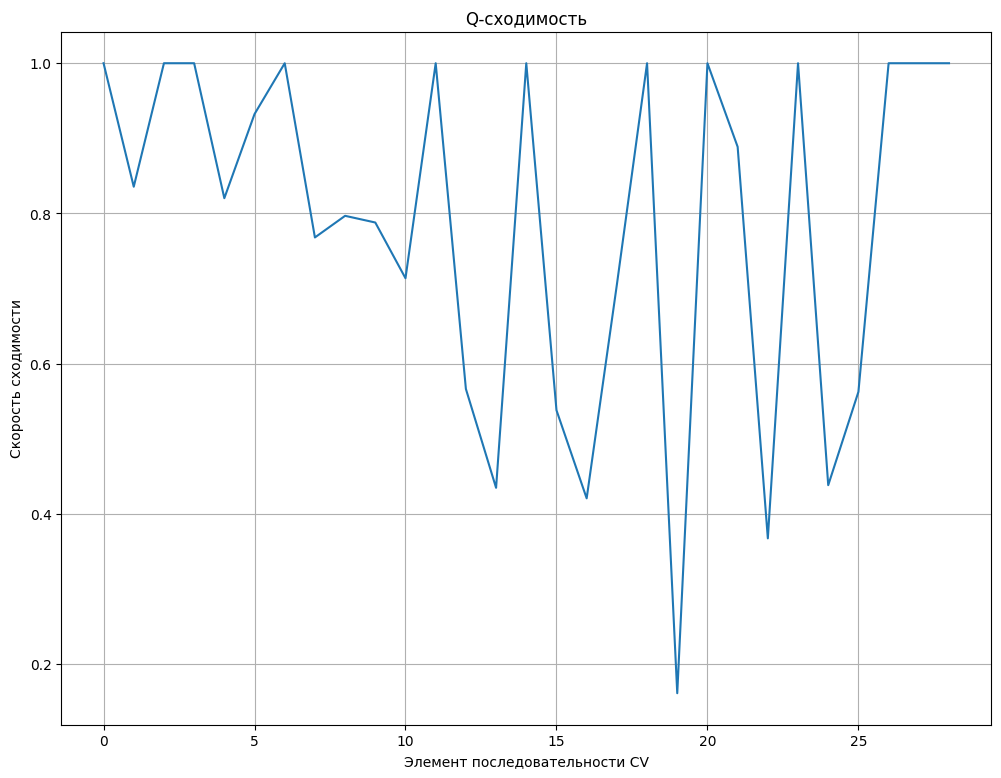

In [10]:
Q_conv1 = np.empty(len(y_hist)-1)
for i in range(len(Q_conv1)):
    Q_conv1[i] = np.abs(y_hist[i+1, 0] - 0)/np.abs(y_hist[i, 0] - 0)

fig2 = plt.figure(figsize=(12, 9))
plt.plot(Q_conv1)
plt.title('Q-сходимость')
plt.xlabel('Элемент последовательности CV')
plt.ylabel('Скорость сходимости')
plt.grid()
plt.show()

In [39]:
num = 100
x_stat_RBF = np.empty([num, 2])
y_stat_RBF = np.empty([num, 1])
L1_stat_RBF = np.empty([num, 1])

for i in range(num):

    target = np.array([random.uniform(-3, 3), random.uniform(-3, 3)])
    model = SinParabolaModel(a = -target, b=2, c=10)  
    
    optimizer_RBF_stat = Optimizer(
                optCls=EvolutionaryOpt,
                seed=i,
                to_model_vec_size=2,
                from_model_vec_size=3,
                iter_limit=60,
                external_model=model.evaluate,
                dimension=2,
                population_size=30,
                offspring_per_parent=2,
                mutation_prob=0.3,
                sigma_init=0.2
            )
    
    for j in range(2):  # Первые 3 параметра - непрерывные
        optimizer_RBF_stat.setVecItemLimit(j, "to_model", min=-3, max=3)
    
    
    optimizer_RBF_stat.modelOptimize()
    ep_optimizer = optimizer_RBF_stat.getOptimizer()
    history = ep_optimizer.get_optimization_history()
    x_stat_RBF[i, :] = history[-1]['best_solution'].copy()
    y_stat_RBF[i, :] = model.evaluate(history[-1]['best_solution']).copy() + 4.0
    L1_stat_RBF[i, :] = np.sum(np.abs(history[-1]['best_solution'].copy() - target.copy()))

    print(f'Done {i+1} out of {num}', end='\r')


In [44]:
num = 100
x_stat_GAUSS = np.empty([num, 2])
y_stat_GAUSS = np.empty([num, 1])
L1_stat_GAUSS = np.empty([num, 1])

for i in range(num):

    target = np.array([random.uniform(-3, 3), random.uniform(-3, 3)])
    model = SinParabolaModel(a = -target, b=2, c=10)   
    
    optimizer = Optimizer(
        optCls              = GaussOpt,
        seed                = i, # TODO: Проверить, точно ли работает. Сейчас выдаёт разные значения при одном seed
        to_model_vec_size   = 2,
        from_model_vec_size = 1,
        iter_limit          = 50,
        external_model = model.evaluate
        )
    optimizer.configure(kernel_cfg=('RBF', {}))
    for j in range(2):  # Первые 3 параметра - непрерывные
        optimizer.setVecItemLimit(j, "to_model", min=-3, max=3)

    optimizer.modelOptimize()
    x = optimizer.getResult()
    x_stat_GAUSS[i, :] =x.copy()
    y_stat_GAUSS[i, :] = model.evaluate(x).copy() + 4.0
    L1_stat_GAUSS[i, :] = np.sum(np.abs(x.copy() - target.copy()))


    print(f'Done {i+1} out of {num}', end='\r')


In [43]:
num = 100
x_stat_SA = np.empty([num, 2])
y_stat_SA = np.empty([num, 1])
L1_stat_SA = np.empty([num, 1])

for i in range(num):

    target = np.array([random.uniform(-3, 3), random.uniform(-3, 3)])
    model = SinParabolaModel(a = -target, b=2, c=10) 
    
    optimizer = Optimizer(
        optCls=SimulatedAnnealingOptimizer,
        seed=1424+i,
        to_model_vec_size=2,
        from_model_vec_size=1,
        iter_limit=1000,  # Уменьшил для более компактного вывода
        external_model=model.evaluate,
        initial_temp=50.0,
        min_temp=1e-5,
        cooling_rate=0.98,
        step_size=0.8,
        penalty_coef=1e6  
    )

    for j in range(2):  # Первые 3 параметра - непрерывные
        optimizer.setVecItemLimit(j, "to_model", min=-3, max=3)
    
    optimizer.modelOptimize()    
    x = optimizer.getResult()
    x_stat_SA[i, :] =x.copy()
    y_stat_SA[i, :] = model.evaluate(x).copy() + 4.0
    L1_stat_SA[i, :] = np.sum(np.abs(x.copy() - target.copy()))

    print(f'Done {i+1} out of {num}', end='\r')


In [48]:
y_stat_RBF

array([[1.38558290e-03],
       [5.74935366e-03],
       [2.38673548e-04],
       [1.73270024e-06],
       [1.26337627e-03],
       [3.92255684e-01],
       [2.94740215e-04],
       [7.60040582e-04],
       [2.44014109e-03],
       [3.90876738e-01],
       [3.90876784e-01],
       [1.11568032e-04],
       [7.84698607e-05],
       [8.41977445e-05],
       [1.51824282e-04],
       [3.53963881e-02],
       [3.74880925e-04],
       [1.87919163e-05],
       [5.07172995e-05],
       [3.68864469e-04],
       [2.47456904e-06],
       [9.71598256e-04],
       [2.17010769e-03],
       [5.64456128e-06],
       [6.61029072e-04],
       [4.60774320e-06],
       [4.48234685e-04],
       [3.46033244e-03],
       [1.42270735e-06],
       [4.48104104e-04],
       [3.88163739e-04],
       [5.84154806e-07],
       [5.06543923e-05],
       [3.56678767e-05],
       [5.23585736e-05],
       [2.89580291e-04],
       [3.71780351e-04],
       [4.07787574e-05],
       [3.90897056e-01],
       [1.77791707e-05],


In [46]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    print(top, mean, bottom)
    print(20*'=')

    return mean, confidence_interval


0.022491299490620585 0.060766548026662245 0.0990417965627039
0.16918405613501875 0.20659293550001206 0.24400181486500538


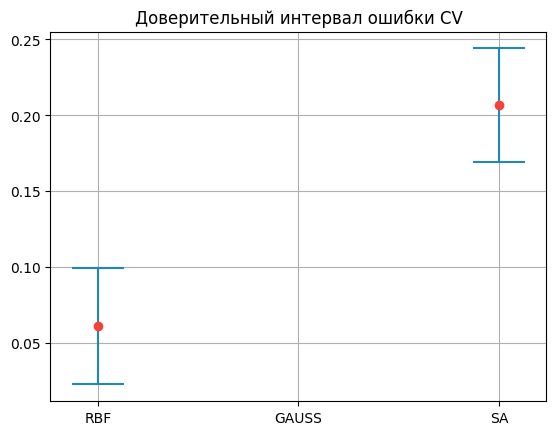

In [55]:
plt.xticks([1, 2, 3, 4], ['RBF', 'GAUSS', 'SA', 'EP'])
plt.title('Доверительный интервал ошибки CV')
plot_confidence_interval(1, y_stat_RBF[:, 0])
# plot_confidence_interval(2, y_stat_GAUSS[:, 0])
plot_confidence_interval(3, y_stat_SA[:, 0])
# plot_confidence_interval(4, y_stat_EP[:, 0])
plt.grid()
plt.show()

0.03871636063482331 0.08329807179831852 0.12787978296181374
0.1852278718942385 0.24190583926395642 0.29858380663367434


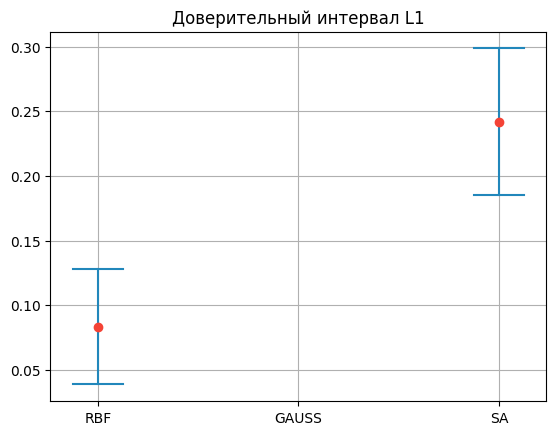

In [54]:
plt.xticks([1, 2, 3, 4], ['RBF', 'GAUSS', 'SA', 'EP'])
plt.title('Доверительный интервал L1')
plot_confidence_interval(1, L1_stat_RBF[:, 0])
# plot_confidence_interval(2, L1_stat_GAUSS[:, 0])
plot_confidence_interval(3, L1_stat_SA[:, 0])
# plot_confidence_interval(4, L1_stat_EP[:, 0])
plt.grid()
plt.show()